# Проект для «Викишоп» c SentanceTranformer

Интернет-магазин **«Викишоп»** запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Требуется обучить модель классифицировать комментарии на позитивные и негативные. Качество модели должно оцениваться метрикой *F1*, и её значение не должно быть меньше 0.75.

В распоряжении набор данных с разметкой о токсичности комментариев. Столбец `text` содержит текст комментария, а `toxic` — оценка этих комментариев: 0 - позитивный, 1 - негативный (целевой класс).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Чтение-и-знакомство-с-данными" data-toc-modified-id="Чтение-и-знакомство-с-данными-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Чтение и знакомство с данными</a></span></li><li><span><a href="#TF-IDF-(CPU)" data-toc-modified-id="TF-IDF-(CPU)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>TF-IDF (CPU)</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#SentanceTranformer-(GPU)" data-toc-modified-id="SentanceTranformer-(GPU)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SentanceTranformer (GPU)</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoost-(CPU)" data-toc-modified-id="CatBoost-(CPU)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoost (CPU)</a></span></li><li><span><a href="#CatBoost-(+-GPU)" data-toc-modified-id="CatBoost-(+-GPU)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoost (+ GPU)</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Баланс-классов" data-toc-modified-id="Баланс-классов-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Баланс классов</a></span></li><li><span><a href="#Изменение-порога-классификации" data-toc-modified-id="Изменение-порога-классификации-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Изменение порога классификации</a></span></li><li><span><a href="#Уменьшение-выборки-(DownSampling)" data-toc-modified-id="Уменьшение-выборки-(DownSampling)-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Уменьшение выборки (DownSampling)</a></span></li></ul></li><li><span><a href="#Итоговое-тестирование" data-toc-modified-id="Итоговое-тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоговое тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

<a id='section_1'></a>
## Подготовка

In [1]:
!pip install -q sentence_transformers catboost

In [2]:
# импорт основных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# импорт спец. библиотек
import os
import re
import nltk
import tensorflow as tf
from nltk.corpus import wordnet
from pymystem3 import Mystem
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer

In [4]:
# импорт элементов библиотеки Scikit-Learn
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
# константы
FIG_SIZE = (7, 6)
RANDOM_STATE = 42

# адреса расположения датасета
HOME_PATH = 'datasets/toxic_comments.csv'
SERVER_PATH = '/datasets/toxic_comments.csv'
GOOGLE_PATH = '/content/drive/Othercomputers/ProBook/Yandex_Practicum/datasets/toxic_comments.csv'

<a id='section_2'></a>
## Чтение и знакомство с данными

In [6]:
# домашняя версия
if os.path.exists(HOME_PATH):
    df = pd.read_csv(HOME_PATH)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    print('Файл прочитан.')

# сетевая версия
elif os.path.exists(SERVER_PATH):
    df = pd.read_csv(SERVER_PATH)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    print('Файл прочитан.')

else: # google версия
    from google.colab import drive
    drive.mount('/content/drive')
    if os.path.exists(GOOGLE_PATH):
        df = pd.read_csv(GOOGLE_PATH)
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
        print('Файл прочитан.')

    # обработка ошибки
    else:
        raise SystemError('Reading was failed. Perhaps, the path was wrong.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Файл прочитан.


----------------< Исходный датасет >----------------


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0



------< Техническая информация >------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None
Дубликаты: 0
Типовые значения колонки 'toxic': [0 1] 



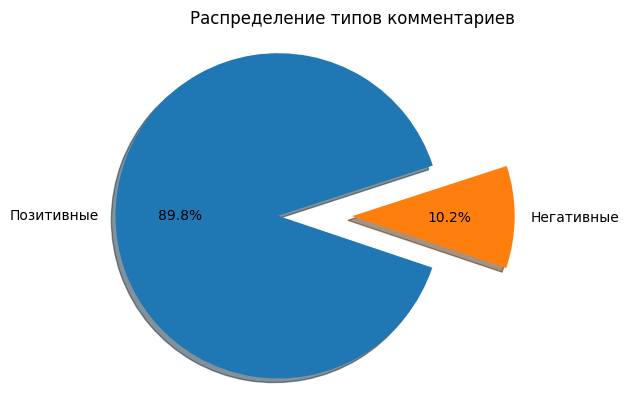

In [7]:
print('----------------< Исходный датасет >----------------')
display(df.head())

print('\n------< Техническая информация >------')
print(df.info())
print("Дубликаты:", len(df[df.duplicated()]))
print("Типовые значения колонки 'toxic':", df['toxic'].unique(), '\n')

# распределение токсичности комментариев
plt.pie(df['toxic'].value_counts(),
        labels=['Позитивные', 'Негативные'],
        autopct='%1.1f%%',
        startangle=18,
        explode=(0.5, 0),
        shadow=True,
        radius=1.10)
plt.title('Распределение типов комментариев');

**Итог:** Датасет содержит почти **160 тыс. комментариев**.
- Колонка `Unnamed: 0` вероятней всего содержала индексы, но в них присутствовали пропуски. По этой причине она была удалена.
- Присутствует дисбаланс классов: позитивных комментариев больше в 9 раз.
- Тип данных соответствует содержанию в колонка.
- Пропуски и дубликаты - отсутствуют.

**Кодирование текста.**
Задача модели, предсказывающей эмоциональный оттенок комментариев, будет разделена на две подзадачи:
- оцифровка текста;
- поиск закономерностей и оценка текста.

Каждая из этих задач будут реализованы отдельными спец. модель. В этом разделе будут разобраны несколько способов преобразования текста.

___

<a id='section_3'></a>
## TF-IDF (CPU)

Самый примитивны способ: использовать только слова встречаемые в исходном тексте.  Обучение и предсказание происходит только на словаре, который сформировывается из слов комментариев.

Оцифровка слов происходит за счёт подсчёта их важности, величиной TF-IDF. То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

_Примечание_: бóльшая величина TF-IDF говорит об уникальности слова в тексте по отношению к корпусу. Чем чаще оно встречается в конкретном тексте и реже в остальных, тем выше значение TF-IDF.

In [8]:
# инициализация класса для лемматизации
WNLemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# функция определение части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# функция лемматизации и очистки текста
def lemm_clear_text(text):
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([WNLemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list])
    lemm_text = re.sub(r'[^ a-zA-Z]', '', lemm_text)
    lemm_text = lemm_text.split()
    lemm_clear_text =  ' '.join(lemm_text)
    return lemm_clear_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Порядок работы функции лемматизации и очистки текста:
1. исходный текст
2. выделение слов и символов в самостоятельные объекты
3. лемматизация слов по отдельности
4. удаление посторонних символов и цифр
5. удаление лишних пробелов. (выделение оставшиеся слов в самостоятельные объекты)
6. финальное объединение слов в одно предложение

In [13]:
# лемматизация текста
tqdm.pandas()
df['lemm_text'] = df['text'].progress_apply(lemm_clear_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [14]:
# пример лемматизации текста
print('Исходный текст:', df.loc[1, 'text'])
print('Лемматизированный:', df.loc[1, 'lemm_text'])

Исходный текст: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Лемматизированный: Daww He match this background colour I m seemingly stuck with Thanks talk January UTC


In [18]:
# (!) для работы в Google Colab без GPU

'''
# сохранение лемматизированного теста
#lemm_dataset_path = '/content/drive/Othercomputers/ProBook/Yandex_Practicum/datasets/toxic_comments_lemm.csv'
#df.to_csv(lemm_dataset_path, index_label=False)

# чтение лемматизированного теста
df['lemm_text'] = pd.read_csv(lemm_dataset_path)['lemm_text']
display(df.head(3))
'''

In [11]:
# скачивание стоп слов
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# создание TF-IDF векторизатора с стоп словами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# подготовка обучающей выборки
target = df['toxic']
features = df['lemm_text']

# выделение тренировочной выборки
X_train_tfidf, X_other, Y_train_tfidf, Y_other = train_test_split(features,
                                                                  target,
                                                                  stratify = target,
                                                                  train_size = 0.80,
                                                                  random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_tfidf, X_test_tfidf, Y_valid_tfidf, Y_test_tfidf = train_test_split(X_other,
                                                                            Y_other,
                                                                            stratify = Y_other,
                                                                            test_size = 0.50,
                                                                            random_state = RANDOM_STATE)

In [16]:
# "кодирование" текста
count_tf_idf.fit(X_train_tfidf)
X_train_tfidf = count_tf_idf.transform(X_train_tfidf)
X_valid_tfidf = count_tf_idf.transform(X_valid_tfidf)
X_test_tfidf  = count_tf_idf.transform(X_test_tfidf)

print('Количество признаков:', X_train_tfidf.shape[1])

Количество признаков: 168669


Далее следует тестирование преобразованного текста. Поскольку в датасете присутствует дисбаланс, а целевая метрика _F1_ демонстрирует условную параллельность _Recall_ и _Precision_.
В дополнении к ней будет выводится значение этих метрик и применяться построение PR-кривой и значения порогов классификации.

Для оценки качества преобразования, закодированный текст сразу будет тестироваться на следующих моделях классификации:
- LogisticRegression;
- CatBoostClassifier.

<a id='section_3A'></a>
### LogisticRegression

In [19]:
# объявление модели Логистической регрессии и её гиперпараметров
LogRer_tfidf = LogisticRegression(C = 11.5,
                                  solver = 'sag',
                                  random_state = RANDOM_STATE)

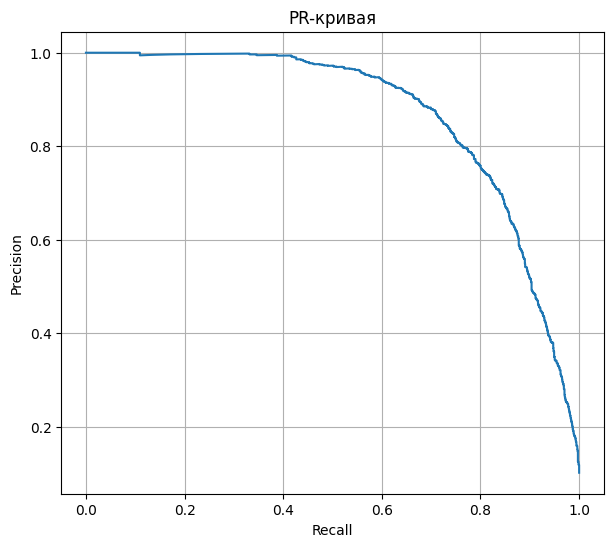

F1 = 0.783
Recall = 0.707
Precision = 0.877


In [27]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf.fit(X_train_tfidf, Y_train_tfidf)
prediction_valid = LogRer_tfidf.predict(X_valid_tfidf)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

<a id='section_3B'></a>
### CatBoost

In [28]:
# модель градиентного бустинга CatBoost (CPU) 16 minutes
CatBoost_tfidf = CatBoostClassifier(verbose = 100, # шаг вывода информации о процессе обучения
                                    task_type = 'CPU', # среда работы модели
                                    max_depth = 3, # макс. глубина базовых моделей
                                    learning_rate = 0.9, # шаг градиентного бустинга
                                    eval_metric = 'F1') # метрика оценки модели

In [ ]:
# обучение CatBoost на фичах TF-IDF
CatBoost_tfidf.fit(X_train_tfidf, Y_train_tfidf)

0:	learn: 0.4315777	total: 764ms	remaining: 12m 43s
100:	learn: 0.7790486	total: 1m 13s	remaining: 10m 52s
200:	learn: 0.8042378	total: 2m 24s	remaining: 9m 33s
300:	learn: 0.8231284	total: 3m 35s	remaining: 8m 19s
400:	learn: 0.8378751	total: 4m 47s	remaining: 7m 8s
500:	learn: 0.8433735	total: 5m 59s	remaining: 5m 57s
600:	learn: 0.8446679	total: 7m 10s	remaining: 4m 46s
700:	learn: 0.8467062	total: 8m 22s	remaining: 3m 34s
800:	learn: 0.8474576	total: 9m 34s	remaining: 2m 22s
900:	learn: 0.8503526	total: 10m 51s	remaining: 1m 11s
999:	learn: 0.8587136	total: 12m 1s	remaining: 0us


In [29]:
# (!) для работы в Colab без GPU

#'''
# сохранение / чтение предобученной модели
CatBoost_tfidf_path = '/content/drive/Othercomputers/ProBook/Yandex_Practicum/CatBoost_TF-IDF.cbm'
CatBoost_tfidf.load_model(CatBoost_tfidf_path, format='cbm')
#CatBoost_tfidf.save_model(CatBoost_tfidf_path, format="cbm", export_parameters=None)
#'''

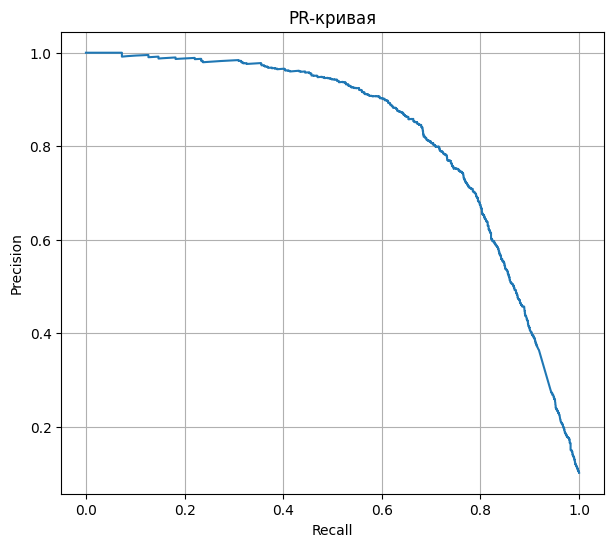

F1 = 0.750
Recall = 0.684
Precision = 0.832


In [30]:
# тестирование TF-IDF на CatBoost
prediction_valid = CatBoost_tfidf.predict(X_valid_tfidf)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

**Итог:**
- Лемматизация текста занимает около 2,5 минут. На этот процесс не влияет применение графического процессора.
- Процесс векторизации подготовленного текста с помощью `TfidfVectorizer` - мгновенный. Слова, не имеющие смысловой нагрузки - удалены.
- Логистическая регрессия имеет значение целевой метрики F1 = 0.78
- Градиентный бустинг CatBoost F1 = 0.75, но время обучения на CPU 15 минут. Применение GPU требует большого объема ОП, что не позволяет его запустить на базовых мощностях Colab.

Ключевым недостатком является большое количество признаков и объём памяти, которую они занимают. Это затрудняет использование GPU, к примеру для ускорения обучения модели CatBoost.

На данном этапе результат тестирования - приемлемый. Но необходимо учесть присутствующий дисбалланс классов. Этой теме будет посвящен отдельный раздел.

___

<a id='section_4'></a>
## SentanceTranformer (GPU)

В этом разделе будет применён альтернативный способ преобразования. TF-IDF векторизатор не учитывает контекст в отличии от предобученной модели для SentanceTranformer. Она позволяет создавать эбеддинги (вектора), которые сохраняют контекст комментариев.

Меньшее количество признаков и требуемый объём ОП позволяет применять GPU и ускорять процесс работы с большим объёмом данных.

In [31]:
# инициализация предобученной модели преобразования текста в вектора
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [32]:
# назначение GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%%time
# кодирование текста CPU 25 minutes
ST_embeddings = []

with tf.device('/device:GPU:0'):
    for i in tqdm(range(len(df['text']))):
        ST_embeddings.append(sentence_transformer.encode(df.loc[i, 'text']))

In [ ]:
%%time
# кодирование текста GPU 3:20 minutes (короткая запись)
ST_embeddings = []

with tf.device('/device:GPU:0'):
    ST_embeddings = sentence_transformer.encode(df['text'])

In [34]:
# (!) для работы в Colab без GPU

#'''
# сохранение / чтение эбеддингов
embeddings_path = '/content/drive/Othercomputers/ProBook/Yandex_Practicum/datasets/ST_embeddings.csv'
#pd.DataFrame(ST_embeddings).to_csv(embeddings_path, index_label=False)

ST_embeddings = pd.read_csv(embeddings_path)
display(ST_embeddings.head())
display(ST_embeddings.info())
#'''

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.028033,0.056780,0.091350,0.032315,0.048531,0.024905,-0.001665,-0.035811,0.015926,-0.019791,...,-0.001886,0.004119,0.005928,0.077336,-0.058341,-0.031362,0.001371,0.014139,-0.026163,-0.041901
1,-0.051320,0.087537,0.055453,-0.061086,0.071453,-0.035208,0.104684,-0.090926,-0.009081,-0.010960,...,0.082233,-0.088611,0.035271,0.029772,0.046203,0.039858,0.092982,0.020118,-0.092164,0.018549
2,0.010958,0.092103,0.051115,0.013316,0.018948,0.023738,-0.033800,-0.098386,0.031458,0.026289,...,-0.015570,0.027781,0.109071,0.068101,0.047131,0.015144,0.022232,-0.060034,0.014200,0.009034
3,-0.009012,-0.036221,0.051822,0.067826,0.083256,0.101421,-0.041176,0.040358,-0.090684,0.007777,...,0.019424,0.046546,0.025812,-0.015300,0.046243,-0.013108,0.030476,0.031271,0.016119,0.054877
4,-0.108289,-0.002620,-0.120247,-0.031936,0.018257,0.051597,-0.008284,-0.025604,-0.056420,0.014543,...,-0.022339,-0.015537,0.059215,-0.016928,0.009169,-0.014318,0.112808,0.089494,-0.086648,-0.038295


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159291
Columns: 384 entries, 0 to 383
dtypes: float64(384)
memory usage: 467.9 MB


None

In [ ]:
# визуализация признаков (эбеддингов)
pd.DataFrame(ST_embeddings).head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.028033,0.056780,0.091350,0.032315,0.048531,0.024905,-0.001665,-0.035811,0.015926,-0.019791,...,-0.001886,0.004119,0.005928,0.077336,-0.058341,-0.031362,0.001371,0.014139,-0.026163,-0.041901
1,-0.051320,0.087537,0.055453,-0.061086,0.071453,-0.035208,0.104684,-0.090925,-0.009081,-0.010960,...,0.082233,-0.088611,0.035271,0.029772,0.046203,0.039858,0.092982,0.020118,-0.092164,0.018549
2,0.010958,0.092103,0.051115,0.013316,0.018948,0.023738,-0.033800,-0.098386,0.031458,0.026289,...,-0.015570,0.027781,0.109071,0.068101,0.047131,0.015144,0.022232,-0.060034,0.014200,0.009034
3,-0.009012,-0.036221,0.051822,0.067826,0.083256,0.101421,-0.041176,0.040358,-0.090684,0.007777,...,0.019424,0.046546,0.025812,-0.015300,0.046243,-0.013108,0.030476,0.031271,0.016119,0.054877
4,-0.108289,-0.002620,-0.120247,-0.031936,0.018257,0.051597,-0.008284,-0.025604,-0.056420,0.014543,...,-0.022339,-0.015537,0.059215,-0.016928,0.009169,-0.014318,0.112808,0.089494,-0.086648,-0.038295


In [35]:
# подготовка обучающей выборки
target = df['toxic']
features = ST_embeddings

# выделение тренировочной выборки
X_train_emb, X_other, Y_train_emb, Y_other = train_test_split(features,
                                                              target,
                                                              stratify = target,
                                                              train_size = 0.80,
                                                              random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_emb, X_test_emb, Y_valid_emb, Y_test_emb = train_test_split(X_other,
                                                                    Y_other,
                                                                    stratify = Y_other,
                                                                    test_size = 0.50,
                                                                    random_state = RANDOM_STATE)

print('Количество признаков:', X_train_emb.shape[1])

Количество признаков: 384


<a id='section_4A'></a>
### LogisticRegression

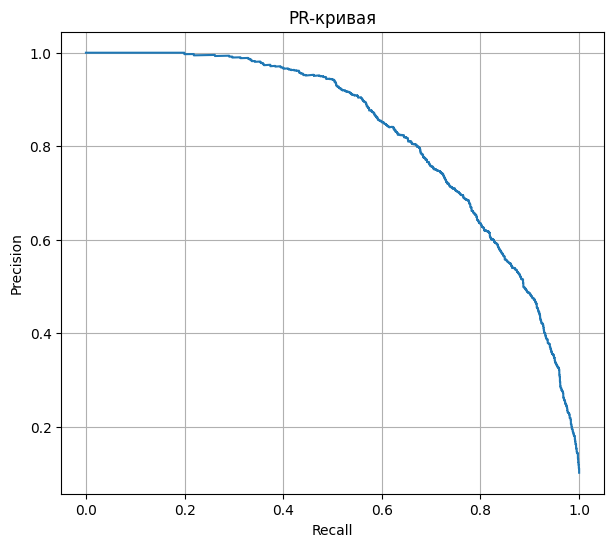

F1 = 0.716
Recall = 0.631
Precision = 0.829


In [36]:
# тестирование SentanceTranformer на Logistic Regression
LogRer_emb = LogisticRegression(solver = 'sag', random_state = RANDOM_STATE)
LogRer_emb.fit(X_train_emb, Y_train_emb)
prediction_valid = LogRer_emb.predict(X_valid_emb)
proba_valid = LogRer_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

<a id='section_4B'></a>
### CatBoost (CPU)

In [37]:
# модель градиентного бустинга CatBoost
CatBoost_cpu_emb = CatBoostClassifier(verbose = 100,
                                      task_type = "CPU",
                                      eval_metric = 'F1', # метрика оценки модели
                                      early_stopping_rounds = 200) # макс. кол-во итераций обучения

In [38]:
# обучение CatBoost на фичах SentanceTranformer (CPU) 4:30 minutes
CatBoost_cpu_emb.fit(X_train_emb, Y_train_emb)

Learning rate set to 0.081637
0:	learn: 0.2639841	total: 595ms	remaining: 9m 54s
100:	learn: 0.6463136	total: 33.9s	remaining: 5m 1s
200:	learn: 0.6966901	total: 1m 3s	remaining: 4m 12s
300:	learn: 0.7312032	total: 1m 32s	remaining: 3m 34s
400:	learn: 0.7581250	total: 2m	remaining: 3m
500:	learn: 0.7792380	total: 2m 29s	remaining: 2m 28s
600:	learn: 0.7962165	total: 3m 5s	remaining: 2m 3s
700:	learn: 0.8134824	total: 3m 35s	remaining: 1m 31s
800:	learn: 0.8288155	total: 4m 2s	remaining: 1m
900:	learn: 0.8449129	total: 4m 28s	remaining: 29.5s
999:	learn: 0.8584131	total: 4m 53s	remaining: 0us


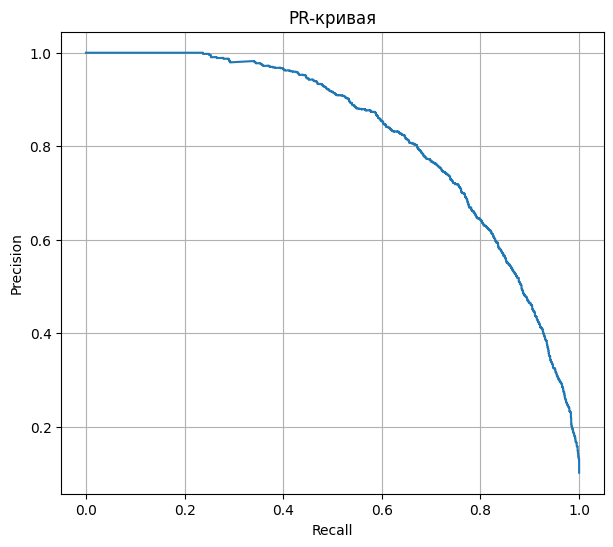

F1 = 0.710
Recall = 0.614
Precision = 0.841


In [39]:
# тестирование SentanceTranformer на CatBoost (CPU)
prediction_valid = CatBoost_cpu_emb.predict(X_valid_emb)
proba_valid = CatBoost_cpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

<a id='section_4C'></a>
### CatBoost (+ GPU)

In [40]:
# модель градиентного бустинга CatBoost (GPU)
CatBoost_gpu_emb = CatBoostClassifier(verbose = 100,
                                      task_type = "GPU",
                                      eval_metric = 'F1',
                                      early_stopping_rounds = 200)

In [41]:
# обучение CatBoost на фичах SentanceTranformer (GPU)
CatBoost_gpu_emb.fit(X_train_emb, Y_train_emb)

Learning rate set to 0.025822
0:	learn: 0.3334906	total: 23.2ms	remaining: 23.2s
100:	learn: 0.5009477	total: 1.4s	remaining: 12.4s
200:	learn: 0.5994770	total: 2.63s	remaining: 10.5s
300:	learn: 0.6403855	total: 3.83s	remaining: 8.89s
400:	learn: 0.6600538	total: 5.04s	remaining: 7.53s
500:	learn: 0.6754930	total: 6.18s	remaining: 6.15s
600:	learn: 0.6878033	total: 7.35s	remaining: 4.88s
700:	learn: 0.6976851	total: 8.49s	remaining: 3.62s
800:	learn: 0.7055594	total: 9.71s	remaining: 2.41s
900:	learn: 0.7135106	total: 15.5s	remaining: 1.7s
999:	learn: 0.7193924	total: 16.7s	remaining: 0us


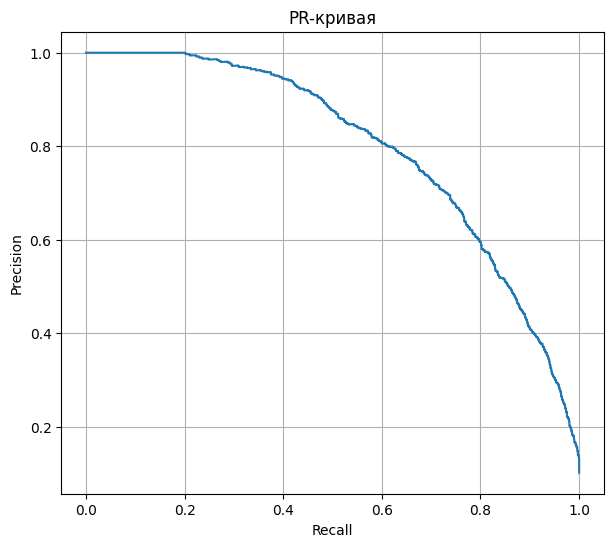

F1 = 0.677
Recall = 0.572
Precision = 0.830


In [42]:
# тестирование SentanceTranformer на CatBoost (GPU)
prediction_valid = CatBoost_gpu_emb.predict(X_valid_emb)
proba_valid = CatBoost_gpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, prediction_valid)))

**Итог:**
- Кодирование текста (создание эбеддингов) с помощью GPU и предобученной модели из SentenceTransformer: 3,5 минуты (CPU 2 часа).
- Логистическая регрессия F1 = 0.72 и небольшое общее время работы: 20 секунд (обучение и предсказание).
- Градиентный бустинг CatBoost (CPU) F1 = 0.71 и 4,5 минут время обучения.
- Градиентный бустинг CatBoost (GPU) F1 = 0.68 и 25 секунд время обучения.

Это промежуточные результаты, поскольку в следующем разделе эти же модели будут тестироваться с учётом присутствующим дисбалансом.

___

<a id='section_5'></a>
## Борьба с дисбалансом

<a id='section_5A'></a>
### Баланс классов

Использование встроенных средств модели, позволяющие стабилизировать разность между классами назначив им разные веса.

In [43]:
# объявление Логистической регрессии с балансом классов
LR_balanced = LogisticRegression(solver = 'sag',
                                 class_weight = 'balanced',
                                 random_state = RANDOM_STATE)

In [44]:
# тестирование TF-IDF на Logistic Regression + баланс классов
LR_balanced.fit(X_train_tfidf, Y_train_tfidf)
balanced_prediction_valid = LR_balanced.predict(X_valid_tfidf)

print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, balanced_prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, balanced_prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, balanced_prediction_valid)))

F1 = 0.751
Recall = 0.855
Precision = 0.670


In [45]:
# тестирование SentanceTranformer на Logistic Regression + баланс классов
LR_balanced.fit(X_train_emb, Y_train_emb)
balanced_prediction_valid = LR_balanced.predict(X_valid_emb)

print('F1 = {:.3f}'.format(f1_score(Y_valid_emb, balanced_prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_emb, balanced_prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_emb, balanced_prediction_valid)))

F1 = 0.648
Recall = 0.888
Precision = 0.510


Если ранее наблюдались заниженные значения полноты (Recall), то балансировка классов, за счёт изменения их веса, изменила положение на противоположное. Метрика F1 либо не изменилась либо ухудшилась.

<a id='section_5B'></a>
### Изменение порога классификации

Поскольку в датасете присутствуют 2 класса, то по-умолчанию объекты распределяются либо в один класс либо в другой с вероятностью 50%.

Но в данной ситуации классы имеют разное соотношение друг к другу, а именно 1:9, не в пользу целевого класса (токсичные комментарии). В данном разделе будет смещаться порог классификации, ради повышения качества предсказания.

In [46]:
# тестирование TF-IDF на Logistic Regression + смещение порога классификации (2 minutes)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_tfidf, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/15819 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.785, при смещении порога до значения 0.40


In [47]:
# тестирование SentanceTranformer на Logistic Regression + смещение порога классификации (2:20 minutes)
proba_valid = LogRer_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_emb, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/15925 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.732, при смещении порога до значения 0.34


In [48]:
# CatBoost TF-IDF + смещение порога классификации (1 minutes)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_tfidf, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/10999 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.755, при смещении порога до значения 0.34


In [49]:
# CatBoost SentanceTransformer + смещение порога классификации (2 minutes)
proba_valid = CatBoost_cpu_emb.predict_proba(X_valid_emb)
precision, recall, thresholds = precision_recall_curve(Y_valid_emb, proba_valid[:, 1])

best_f1 = 0
for threshold in tqdm(thresholds):
    prediction_valid = proba_valid[:, 1] > threshold
    f1 = f1_score(Y_valid_emb, prediction_valid)
    if best_f1 < f1:
        best_f1 = f1
        best_threshold = threshold

print("Наивысший показатель F1 = {:.3f}, при смещении порога до значения {:.2f}".format(best_f1, best_threshold))

  0%|          | 0/15923 [00:00<?, ?it/s]

Наивысший показатель F1 = 0.737, при смещении порога до значения 0.31


Смещение порога классификации однозначно помогает учесть дисбаланс и повысить численность верно классифицированных объектов.

<a id='section_5C'></a>
### Уменьшение выборки (DownSampling)

Поскольку исходный  датасет содержит большое количество объектов (160 тыс.), есть возможность воспользоваться этим, чтобы уменьшить многочисленный класс и воссоздать баланс.

In [50]:
# деление признаков по классам
target_1   = Y_train_tfidf[Y_train_tfidf == 1]
target_0   = Y_train_tfidf[Y_train_tfidf == 0]
features_1 = df.loc[target_1.index, 'lemm_text']
features_0 = df.loc[target_0.index, 'lemm_text']

# уменьшение выборки многочисленного класса
Y_downsampled = pd.concat([target_0.sample(frac=(1/9),   random_state=RANDOM_STATE)] + [target_1])
X_downsampled = pd.concat([features_0.sample(frac=(1/9), random_state=RANDOM_STATE)] + [features_1])
X_downsampled = count_tf_idf.transform(X_downsampled)

In [56]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf_sd = LogisticRegression(solver = 'sag', random_state = RANDOM_STATE)
LogRer_tfidf_sd.fit(X_downsampled, Y_downsampled)
prediction_valid = LogRer_tfidf_sd.predict(X_valid_tfidf)
proba_valid = LogRer_tfidf_sd.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

F1 = 0.697
Recall = 0.870
Precision = 0.582


In [57]:
# обучение CatBoost на ресемплированных фичах TF-IDF
CatBoost_tfidf_sd = CatBoostClassifier(verbose = 100, eval_metric = 'F1', early_stopping_rounds = 200)
CatBoost_tfidf_sd.fit(X_downsampled, Y_downsampled)

Learning rate set to 0.041186
0:	learn: 0.5098735	total: 591ms	remaining: 9m 50s
100:	learn: 0.7992996	total: 58s	remaining: 8m 36s
200:	learn: 0.8385563	total: 1m 54s	remaining: 7m 35s
300:	learn: 0.8615111	total: 2m 50s	remaining: 6m 36s
400:	learn: 0.8765783	total: 3m 50s	remaining: 5m 43s
500:	learn: 0.8893765	total: 4m 46s	remaining: 4m 45s
600:	learn: 0.8996713	total: 5m 39s	remaining: 3m 45s
700:	learn: 0.9068105	total: 6m 35s	remaining: 2m 48s
800:	learn: 0.9135351	total: 7m 33s	remaining: 1m 52s
900:	learn: 0.9180620	total: 8m 26s	remaining: 55.7s
999:	learn: 0.9231702	total: 9m 21s	remaining: 0us


In [58]:
# тестирование TF-IDF на CatBoost (CPU)
prediction_valid = CatBoost_tfidf.predict(X_valid_tfidf)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

F1 = 0.750
Recall = 0.684
Precision = 0.832


Уменьшение выборки не позволило повысить значения рассматриваемых метрик, и фактически результат искусственный, поскольку игнорирует действительность.
___

<a id='section_6'></a>
## Итоговое тестирование

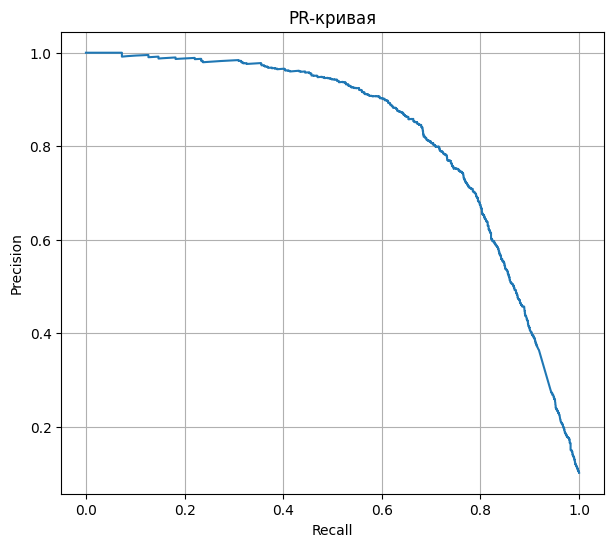

F1 = 0.774
Recall = 0.771
Precision = 0.777


In [59]:
# финальный тест TF-IDF на Logistic Regression + смещение порога классификации
proba_test = LogRer_tfidf.predict_proba(X_test_tfidf)
prediction_test = proba_test[:, 1] > 0.25
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test)))

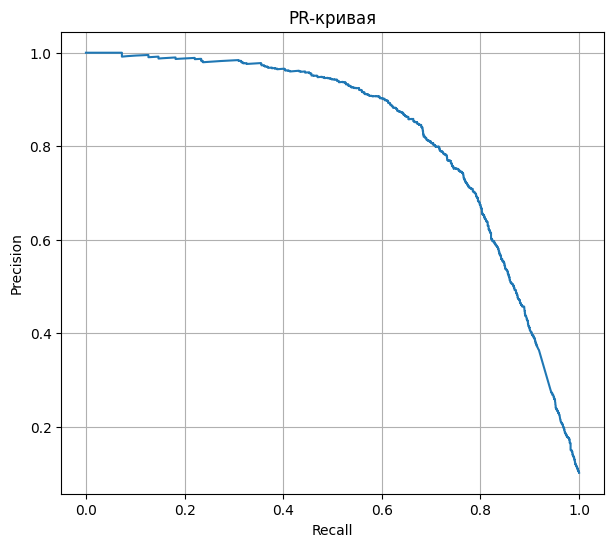

F1 = 0.757
Recall = 0.692
Precision = 0.835


In [60]:
# финальный тест TF-IDF на CatBoost + смещение порога классификации
proba_test = CatBoost_tfidf.predict_proba(X_test_tfidf)
prediction_test = proba_test[:, 1] > 0.49
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_test_tfidf, prediction_test)))
print('Recall = {:.3f}'.format(recall_score(Y_test_tfidf, prediction_test)))
print('Precision = {:.3f}'.format(precision_score(Y_test_tfidf, prediction_test)))

**Выводы**

Можно выделить основные критерии оценки модели:
- Время и ресурсы кодирование текста
- Время и ресурсы обучения модели
- Время предсказания
- Итоговое значение метрики

Логистическая регрессия в кооперативе с TF-IDF векторизатором являются наилучшим результатом, поскольку подготовка и кодирование занимает около 25 минут, обучение регрессии (20 секунд), предсказание - мгновенное. Для работы такой пары не требуется GPU в качестве аппаратного ускорителя.

Итоговое значение метрики F1 выше у Логистической регрессии, и в добавок метрики более сбалансированны, если посмотреть на значения Recall и Precision.

Модель CatBoost может выдать предсказания более высшего качества, но для этого требуется более кропотливая настройка её гиперпараметров и дополнительное время работы. Процесс сильно зависим от технических мощностей компьютера/сервера.